# Connector API
this API takes a dictionary `con_dict` containing a list of management IP addesses given to a routers which is SSH enabled, along with the SSH username and passwords. 

## Configure Management Interface
Enter connection parameters into a __.csv__ file, supply the file location to __`conn_file`__ argument of __`gen_management_script`__ function, to see the file's content set True to __`show_file`__ argument. This generates management script, Copy and paste the script to the router while in priviledge mode. 

In [1]:
import napalm as npm
import pandas as pd
import threading 
import networkx as nx

In [2]:
def gen_ssh_script(conn_file, show_file):
    
    '''
    Generates SSH config for Cisco Routers 
    @Author : Saptarshi Ghosh
    @Arguments
        conn_file : STRING, file location to config CSV file
        show_file : BOOLEAN, if you want to see file content 
    '''
    
    import pandas as pd
    con_params = pd.read_csv(conn_file)
    if show_file:
        print('Input params \n')
        print(con_params)
    print("\n\nConfigurations")
    for i in range(con_params.shape[0]):
        r_param  = con_params.iloc[i].to_dict()
        print('--------------------------------------------')
        print(f"{r_param['Router_name']}")
        print('--------------------------------------------')
    
        print(f" \
        conf t   \n \
        hostname {r_param['Router_name']} \n \
        ena secret {r_param['Secret']} \n \
        int  {r_param['Manage_iface']} \n \
            ip add {r_param['IP_address']} \n \
            no sh \n \
        exit \n \
        ip ssh ver 2 \n \
        ip domain-name {r_param['Domain_name']} \n \
        user {r_param['Username']} password {r_param['Password']} \n \
        crypto key gen rsa gen mod {r_param['Key_len']} \n \
        line vty 0 4 \n \
            transport input ssh \n \
            transport output ssh \n \
            login local \n \
        end" )

In [4]:
gen_ssh_script(conn_file='configs/management_specs.csv', show_file=True)

Input params 

  Router_name Manage_iface IP_address Domain_name Username Password  Key_len  \
0     router1         E1/0       dhcp  lsbu.ac.uk    user2  pass123     2048   
1     router2         E1/0       dhcp  lsbu.ac.uk    user1     pass     2048   
2     router3         E1/0       dhcp  lsbu.ac.uk    user1     pass     2048   

  Secret  
0  cisco  
1  cisco  
2  cisco  


Configurations
--------------------------------------------
router1
--------------------------------------------
         conf t   
         hostname router1 
         ena secret cisco 
         int  E1/0 
             ip add dhcp 
             no sh 
         exit 
         ip ssh ver 2 
         ip domain-name lsbu.ac.uk 
         user user2 password pass123 
         crypto key gen rsa gen mod 2048 
         line vty 0 4 
             transport input ssh 
             transport output ssh 
             login local 
         end
--------------------------------------------
router2
----------------------------

## Connect to the routers 
1. Go to the router's terminal and fire the command `sh ip interface brief | exclude unassigned` and copy the IP address assigned on the given interface. 
2. create another csv file list the corresponsing __`IP address, username and password`__ here we use the file  __`credentials.csv`__
3. the __`Init_con`__ function will initiate a SSH connection to the given routers  
4. write the follwing config to __`~/.ssh/config`__ file
```
Host 0.0.0.0
    KexAlgorithms +diffie-hellman-group1-sha1
```

In [5]:
p_lock = threading.Lock()

def init_param(cred_dict):
    # create a driver 
    driver = npm.get_network_driver('ios')
    
    router_obj_list=[]
    # create a routre Object list
    
    for i in range(len(cred_dict['ip_list'])):
        router_obj_list.append(driver(hostname=cred_dict['ip_list'][i], 
                                      username=cred_dict['uname_list'][i], 
                                      password=cred_dict['pass_list'][i],
                                      optional_args={'secret' : cred_dict['sec_list'][i]})
                              )
    
    return router_obj_list

In [6]:
def th_func(ro):
    ro.open()
    temp = ro.get_facts()
    print(f"\t Connection to {temp['vendor']} {temp['model']} Successfull... !")
    
def open_conn_MT(router_obj_list):
    thread_list=[]
    for ro in router_obj_list:
        thread_list.append(threading.Thread(target=th_func, args=(ro,)))
    for th in thread_list:
        th.start()
    for th in thread_list:
        th.join()

In [7]:
net = []        
def fetch_rt(router, route_type, mgmt_net):
    cmd=f'sh ip route {route_type}'
    rows = router.cli([cmd])[cmd].split('\n')
    prefix=[]
    for i in rows:
        if mgmt_net not in i:
            a=i.split(' ')[4]
            if '/' in a:
                prefix.append(a)
            else:
                b = i.split(' ')[5]
                if '/' in b:
                    prefix.append(b)
    with p_lock:
        net.append(prefix)

def get_routing_tables(ro_list, route_type, mgmt_net ):
    thread_list =[]
    for j in range(len(ro_list)):
        thread_list.append(threading.Thread(target=fetch_rt , 
                                            args=(ro_list[j], route_type, mgmt_net)
                                           )
                          )
    for th in thread_list:
        th.start()
    for th in thread_list:
        th.join()
    return net

In [8]:
def gen_graph(n):
    import matplotlib.pyplot as plt
    import networkx as nx
    %matplotlib inline
    
    for i in n:
        print(i)
    
    g=nx.Graph()
    plt.figure(figsize=(15,10))
    e_list=[]
    for r in range(len(n)):
        for i in range(len(n[r])):
            for j in range(i+1,len(n[r])):
                e_list.append( (n[r][i],n[r][j]) )
    e_list
    #print(e_list)
    g.add_edges_from(e_list)
    nx.draw_networkx(g,pos=nx.spiral_layout(g));
    plt.show()
    return g

In [9]:
def get_APSP(topology):
    nets = list(topology.nodes())
    apsp = []
    for s in range(len(nets)):
        for d in range(s+1, len(nets)):
            apsp.append( {'src' : nets[s],
                          'dst' : nets[d],
                          'path': nx.dijkstra_path(topology,
                                                   source=nets[s],
                                                   target=nets[d])
                
            })
    for sp in apsp:
        print(f"{sp['src']} <---> {sp['dst']} \n \
                {sp['path']}\n")

In [10]:
def init_con(cred_file, show_file):
    global net
    net = []
    credentials = pd.read_csv(cred_file)
    print(credentials)
    print('\n')
    ro_list = init_param( cred_dict=
                         { 'ip_list'   : credentials['IP_address'].tolist(),
                           'uname_list': credentials['Username'].tolist(),
                           'pass_list' : credentials['Password'].tolist(),
                           'sec_list'  : credentials['Secret'].tolist()} 
              )
    
    print('Eshtablishing Secure Connection to Routers...')
    open_conn_MT(router_obj_list = ro_list)

    print('Accumulating Connected Routes...')
    net = get_routing_tables(ro_list=ro_list, route_type='conn', mgmt_net='192.168.122.0')

    print('Generating Topology View...')
    topo = gen_graph(n = net)

    print('Calculating Proactive SPF... ')
    get_APSP(topology=topo)

    return ro_list

        IP_address Username Password Secret
0  192.168.122.233    user1     pass  cisco
1  192.168.122.209    user1     pass  cisco
2  192.168.122.111    user1     pass  cisco


Eshtablishing Secure Connection to Routers...
	 Connection to Cisco 3660 Successfull... !
	 Connection to Cisco 3660 Successfull... !
	 Connection to Cisco 3660 Successfull... !
Accumulating Connected Routes...
Generating Topology View...
['23.0.0.0/24', '192.168.5.0/24', '192.168.6.0/24', '13.0.0.0/24']
['23.0.0.0/24', '192.168.4.0/24', '12.0.0.0/24', '192.168.3.0/24']
['12.0.0.0/24', '192.168.1.0/24', '13.0.0.0/24', '192.168.2.0/24']


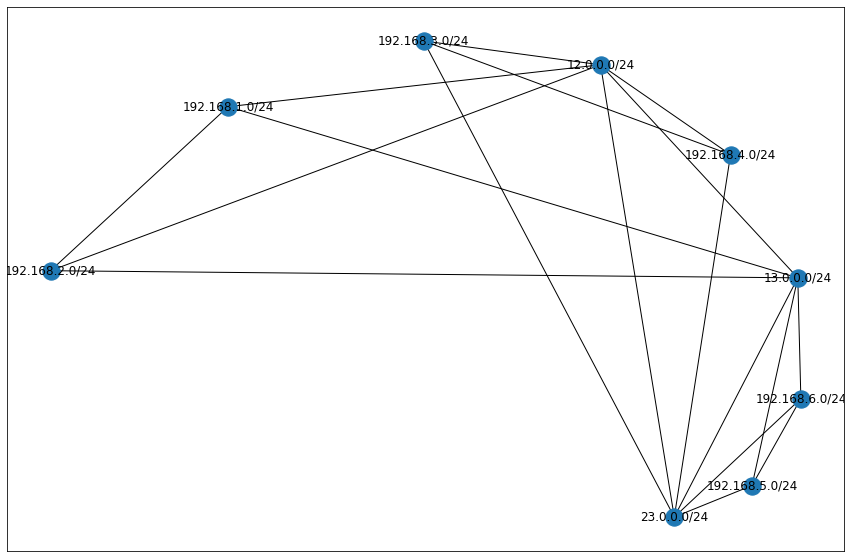

Calculating Proactive SPF... 
23.0.0.0/24 <---> 192.168.5.0/24 
                 ['23.0.0.0/24', '192.168.5.0/24']

23.0.0.0/24 <---> 192.168.6.0/24 
                 ['23.0.0.0/24', '192.168.6.0/24']

23.0.0.0/24 <---> 13.0.0.0/24 
                 ['23.0.0.0/24', '13.0.0.0/24']

23.0.0.0/24 <---> 192.168.4.0/24 
                 ['23.0.0.0/24', '192.168.4.0/24']

23.0.0.0/24 <---> 12.0.0.0/24 
                 ['23.0.0.0/24', '12.0.0.0/24']

23.0.0.0/24 <---> 192.168.3.0/24 
                 ['23.0.0.0/24', '192.168.3.0/24']

23.0.0.0/24 <---> 192.168.1.0/24 
                 ['23.0.0.0/24', '13.0.0.0/24', '192.168.1.0/24']

23.0.0.0/24 <---> 192.168.2.0/24 
                 ['23.0.0.0/24', '13.0.0.0/24', '192.168.2.0/24']

192.168.5.0/24 <---> 192.168.6.0/24 
                 ['192.168.5.0/24', '192.168.6.0/24']

192.168.5.0/24 <---> 13.0.0.0/24 
                 ['192.168.5.0/24', '13.0.0.0/24']

192.168.5.0/24 <---> 192.168.4.0/24 
                 ['192.168.5.0/24', '23.0.0.0/24'

In [13]:
init_con(cred_file='configs/credentials.csv',show_file=True)

In [ ]:
r1 = {'name': 'r1', 'ro' : ['12.0.0.0' , '13.0.0.0'] , 'iface' : ['f0/0' , 'f0/1']}
r2 = {'name': 'r2', 'ro' : ['12.0.0.0' , '23.0.0.0'] , 'iface' : ['f0/0' , 'f0/1']}
r3 = {'name': 'r3', 'ro' : ['13.0.0.0' , '23.0.0.0'] , 'iface' : ['f0/0' , 'f0/1']}

router_list = [r1,r2,r3]
r=[]
ret = {}
for ri in rl:
    r+=ri['ro']
net_id_list=list(set(r))

for net_id in net_id_list:
    ret[ net_id ] = []
    for router in router_list:
        if net_id in router['ro']:
            ret[ net_id ].append(router['name'])
ret

In [ ]:
def build_incidence_matrix(router_list):
    net_list = []
    for router in router_list:
        net_list += router['ro']
    net_list = list( set(net_list) )

    print(net_list)
    inc_mat = {}
    
    for net_id in net_list:
        inc_mat[net_id]=[]
        for router in router_list:
            for i in range(len(router['ro'])):
                if router['ro'][i] == net_id:
                    inc_mat[net_id].append(router['name']+_+router['iface'][i])
    print(inc_mat)
    

In [ ]:
build_incidence_matrix(router_list)

In [ ]:
router_list

In [ ]:
a=[1,1,3]

In [ ]:
[a == 1]

In [ ]:
g=nx.Graph()

In [ ]:
n = [['192.168.1.0','192.168.2.0','12.0.0.0'],
     ['192.168.3.0','192.168.4.0','12.0.0.0','23.0.0.0'],
     ['192.168.5.0','192.168.6.0','23.0.0.0']]

In [ ]:
n

In [ ]:
nx.shortest_path(g, source='192.168.1.0', target='192.168.5.0')

In [ ]:
a=[1,2,3,4]

In [ ]:
a.remove(2)

In [ ]:
a